# Классификация пород собак с использованием EfficientNetV2B0

**Описание проекта:**

В этом ноутбуке мы создаем модель для классификации пород собак на основе датасета Stanford Dogs
. Мы используем предварительно обученную модель EfficientNetV2B0, добавляем аугментацию изображений, выполняем обучение с заморозкой и последующей разморозкой верхних слоев, а также проверяем качество модели на тестовой картинке.

### Импорт библиотек

Пояснение:
импортируем необходимые библиотеки, задаем размер изображений и размер батча.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import data as tf_data
import os
import keras
from keras import layers

IMAGE_SIZE = (224, 224) # Размер определен выбором модели
BATCH_SIZE = 128

Пояснение: будем использовать EfficientNetV2B0 как базовую модель для переноса обучения.

In [3]:
from tensorflow.keras.applications import EfficientNetV2B0

### Набор данных

Пояснение: загружаем датасет Stanford Dogs с Yandex Cloud.

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip

Пояснение: распаковываем архив и задаем путь к основным папкам с изображениями.

In [5]:
# Разархивируем датасет во временную папку 'temp'
!unzip -qo "stanford_dogs" -d ./dataset

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = './dataset/'

### Фильтрация поврежденных изображений

Пояснение: проверяем изображения на повреждения и удаляем их, если они некорректны.

In [6]:
num_skipped = 0 # счетчик поврежденных файлов
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь
    for fname in os.listdir(folder_path): # получаем список файлов в папке
        fpath = os.path.join(folder_path, fname) # получаем путь до файла
        try:
            fobj = open(fpath, "rb") # пытаемся открыть файл для бинарного чтения (rb)
            is_jfif = b"JFIF" in fobj.peek(10) # получаем первые 10 байт из файла и ищем в них бинарный вариант строки JFIF
        finally:
            fobj.close() # Закрываем файл

        if not is_jfif: # Если не нашли JFIF строку
            # Увеличиваем счетчик
            num_skipped += 1
            # Удаляем поврежденное изображение
            os.remove(fpath)

print(f"Удалено изображений: {num_skipped}")

Удалено изображений: 10


### Генерация датасета

Пояснение: создаем обучающий и проверочный наборы данных с разделением 80/20.

In [7]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH, # путь к папке с данными
    validation_split=0.2, # отщепляем 20% на проверочную выборку
    subset="both", # указываем, что необходимо вернуть кортеж из обучающей и проверочной выборок ("training", "validation" или "both")
    seed=42,  # воспроизводимость результата генерации (результаты с одинаковым числом - одинаковы),
    shuffle=True, # перемешиваем датасет
    image_size=IMAGE_SIZE, # размер генерируемых изображений
    batch_size=BATCH_SIZE, # размер мини-батча
)

Found 20570 files belonging to 120 classes.
Using 16456 files for training.
Using 4114 files for validation.


Определение меток датасета:

In [8]:
# Определяем список имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определяем количества классов
CLASS_COUNT = len(CLASS_LIST)

# Вывод результата
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 120
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Groenendael', 'Ibizan_hound',

### Аугментация данных

Пояснение: создаем функции аугментации для улучшения обобщающей способности модели.

In [9]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15), # Вращаем изображение в пределах 15%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Сдвиг на 10% по вертикали и горизонтали
    layers.RandomFlip(), # Отражение по вертикали и горизонтали
    layers.RandomContrast(factor=0.1), # Изменяем контрастность на 10%
]


def img_augmentation(images):
    # Слои - это функции, которые мы последовательно применяем к входным данным
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

### Предварительная обработка данных

Пояснение: применяем аугментацию к обучающему набору и преобразуем метки в one-hot формат. Используем prefetch для ускорения обработки.

In [10]:
# Применяем `img_augmentation` к обучающей выборке
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

# Предварительная выборка примеров в память GPU или оперативную память
# Помогает максимально эффективно использовать графический процессор
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

### Вспомогательные функции

Пояснение: функция для визуализации точности и потерь во время обучения.

In [11]:
def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

### Перенос обучения

Пояснение: создаем модель с предобученной EfficientNetV2B0 и верхними слоями для классификации.

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetV2B0

def build_model(num_classes, image_size=(224, 224), dropout_rate=0.2):
    inputs = layers.Input(shape=(image_size[0], image_size[1], 3))
    base_model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Заморозка базовой модели
    base_model.trainable = False

    # Верхние слои
    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = keras.Model(inputs, outputs, name="EfficientNetV2B0")

    # Компиляция
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model


### Обучение с заморозкой базовой модели

Пояснение: обучаем верхние слои модели, базовая часть пока заморожена.

In [15]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model_pretrain.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

model = build_model(num_classes=CLASS_COUNT)


history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2366 - loss: 3.5290

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_acc available.
  if self._should_save_model(epoch, batch, logs, filepath):


129/129 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.2377 - loss: 3.5218 - val_accuracy: 0.8138 - val_loss: 1.2594
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.5685 - loss: 1.5862 - val_accuracy: 0.8415 - val_loss: 0.5835
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.6116 - loss: 1.3970 - val_accuracy: 0.8493 - val_loss: 0.4781
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.6447 - loss: 1.2642 - val_accuracy: 0.8544 - val_loss: 0.4565
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.6511 - loss: 1.2077 - val_accuracy: 0.8532 - val_loss: 0.4544
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.6710 - loss: 1.1574 - val_accuracy: 0.8583 - val_loss: 0.4520
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.6863 - loss: 1.0898 - val_accuracy: 0.8551 - val_loss: 0.4556
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.6955 - loss: 1.0485 - val_accuracy: 0.855

### Разморозка весов

Пояснение: размораживаем верхние слои модели и дообучаем с маленьким шагом обучения. Визуализируем метрики.

Epoch 1/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - acc: 0.7602 - loss: 0.7884 - val_acc: 0.8636 - val_loss: 0.4519
Epoch 2/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - acc: 0.7538 - loss: 0.7947 - val_acc: 0.8629 - val_loss: 0.4487
Epoch 3/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - acc: 0.7687 - loss: 0.7612 - val_acc: 0.8636 - val_loss: 0.4468
Epoch 4/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - acc: 0.7651 - loss: 0.7697 - val_acc: 0.8636 - val_loss: 0.4459


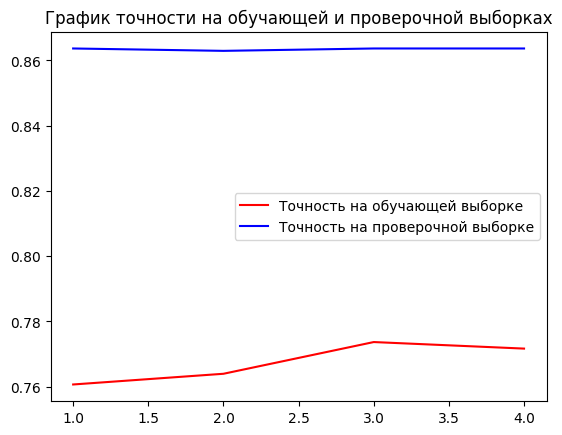

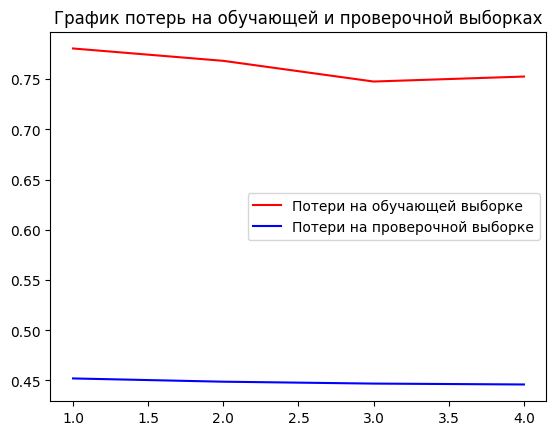

In [16]:
def unfreeze_model(model):
    # Мы размораживаем 20 верхних слоев за исключением BatchNormalization
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    # В оптимизаторе устанавливаем маленький шаг обучения
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )


unfreeze_model(model)

epochs = 4
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
show_plot(history)

### Проверка модели

Пояснение: проверяем работу модели на отдельном изображении. Выводим предсказанную и истинную породу.

--2025-10-22 21:25:17--  https://storage.yandexcloud.net/academy.ai/Cardigan.jpeg
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47310 (46K) [image/jpeg]
Saving to: ‘Cardigan.jpeg’

Cardigan.jpeg       100%[===================>]  46.20K   157KB/s    in 0.3s    

2025-10-22 21:25:19 (157 KB/s) - ‘Cardigan.jpeg’ saved [47310/47310]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

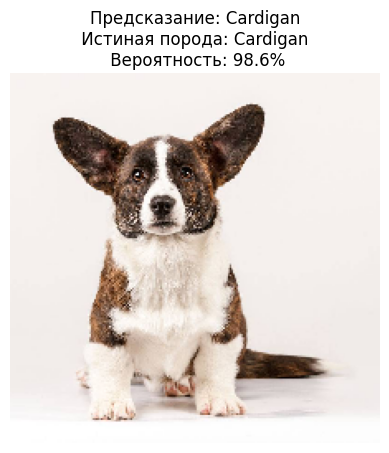

In [17]:
!wget https://storage.yandexcloud.net/academy.ai/Cardigan.jpeg
TEST_IMG='./Cardigan.jpeg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Cardigan \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")


### Итог:

* Загружен и подготовлен датасет Stanford Dogs.

* Создана и обучена модель EfficientNetV2B0 с переносом обучения и аугментацией данных.

* Проведена проверка модели на тестовом изображении.

* Визуализированы точность и потери на обучающей и проверочной выборках.